In [28]:
import numpy as np
import scipy as sci
import matplotlib.pylab as plt

In [29]:
from astropy.io import ascii
gw170817 = ascii.read('gw170817_afterglow_data_full.txt')

In [30]:
print(gw170817)

         DateUT            T    Telescope      Freq       FluxD  FluxDErr
------------------------ ------ --------- -------------- ------- --------
          2017-Aug-18.10   0.57       VLA   9700000000.0    <144       --
           2017-Aug-18.1    0.6     Swift       2.41e+17 <7.8e-3       --
          2017-Aug-18.21   0.68      ATCA   8500000000.0    <120       --
          2017-Aug-18.21   0.68      ATCA  10500000000.0    <150       --
           2017-Aug-18.2    0.7    NuSTAR        1.2e+18 <7.3e-4       --
          2017-Aug-18.46   0.93     uGMRT    610000000.0    <195       --
           2017-Aug-18.5    1.0     Swift       2.41e+17 <7.5e-2       --
           2017-Aug-18.6    1.1     Swift       2.41e+17 <5.0e-3       --
          2017-Aug-18.95   1.43      ALMA 339000000000.0    <126       --
          2017-Aug-18.97   1.44       VLA  10000000000.0   <13.8       --
                     ...    ...       ...            ...     ...      ...
         2019-Sep-21--27  767.0       

In [31]:
print(gw170817["FluxD"].dtype)

<U7


In [32]:
gw170817['FluxD_float'] = [float(val.strip("<")) for val in gw170817["FluxD"]]

In [33]:
VLA = gw170817[(gw170817["Telescope"] == "VLA") & (gw170817["Freq"] == 4.50e9)]
MeerKAT = gw170817[gw170817["Telescope"] == "MeerKAT"]

In [34]:
print(VLA, MeerKAT)

    DateUT      T   Telescope     Freq     FluxD  FluxDErr FluxD_float
------------- ----- --------- ------------ ------ -------- -----------
2017-Oct-28.7  72.2       VLA 4500000000.0 5.60e1      8.0        56.0
2017-Oct-29.7  73.2       VLA 4500000000.0 5.40e1      8.0        54.0
 2017-Nov-4.7  79.2       VLA 4500000000.0 4.50e1      7.0        45.0
2018-Apr-1-10 229.0       VLA 4500000000.0 4.80e1      6.0        48.0       DateUT        T   Telescope     Freq     FluxD  FluxDErr FluxD_float
----------------- ----- --------- ------------ ------ -------- -----------
      2018-Jan-20 155.0   MeerKAT 1300000000.0 1.51e2     23.0       151.0
       2018-Mar-3 197.0   MeerKAT 1300000000.0 1.07e2     17.0       107.0
      2018-Apr-26 252.0   MeerKAT 1300000000.0 7.40e1      9.0        74.0
       2018-May-6 261.0   MeerKAT 1300000000.0 6.60e1     10.0        66.0
       2018-Jul-8 324.0   MeerKAT 1300000000.0 4.50e1     13.7        45.0
       2018-Sep-2 380.0   MeerKAT 1300000000.0 3.

In [35]:
def check_valid_points(table):
    npoints = 0
    for i in range(len(table)):
        flux = table['FluxD'][i]
        ferr = table['FluxDErr'][i]
        if (isinstance(flux, str) and flux.startswith('<')) or ferr == '--':
            continue
        npoints += 1
    print(f"Number of usable data points: {npoints}")

print("VLA valid points:")
check_valid_points(VLA)

print("MeerKAT valid points:")
check_valid_points(MeerKAT)

VLA valid points:
Number of usable data points: 4
MeerKAT valid points:
Number of usable data points: 6


In [36]:
def broken_power_law(t, f, a_1, a_2, b, s, F_p, t_p):
    F = np.power(f/(3 * 10**9), b) * F_p * np.power(np.power(t/t_p, -s*a_2) + np.power(t/t_p, -s*a_2), -1/s)
    return F

In [37]:
def log_likelihood(params, table):
    a_1, a_2, b, s, F_p, t_p = params
    logL = 0.0
    nrows = len(table)
    for i in range(nrows):
        flux = table['FluxD'][i]
        ferr = table['FluxDErr'][i]
        # Skip upper limits or missing errors
        if (isinstance(flux, str) and flux.startswith('<')) or ferr == '--':
            continue
        t = float(table['T'][i])
        f = float(table['Freq'][i])
        mu = broken_power_law(t, f, a_1, a_2, b, s, F_p, t_p)
        logL += -0.5 * ((float(flux) - mu)/float(ferr))**2
    return logL

In [38]:
def log_prior(params):
    a_1, a_2, b, s, F_p, t_p = params
    
    # Example prior ranges
    if not (0 < a_1 < 2):
        return -np.inf
    if not (0.5 < a_2 < 5):
        return -np.inf
    if not (0.4 < b < 1):
        return -np.inf
    if not (10 < t_p < 400):
        return -np.inf
    if not (0.01 < F_p < 100): 
        return -np.inf
    if not (1 < s < 30):
        return -np.inf
    
    # Flat prior within bounds. The prior value is 1, and hence, log prior is zero.
    return 0.0

In [39]:
def log_posterior(params, table):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(params, table)
    return lp + ll

In [40]:
def posterior(params, table):
    logp = log_posterior(params, table)
    if not np.isfinite(logp):
        return 0.0
    return np.exp(logp)

In [41]:
def propose(params, step_sizes):
    return params + np.random.normal(0, step_sizes, size=len(params))

In [42]:
def MH_MCMC(f, g, a, n = 100000):
    A = [a]
    while len(A) <= n:
        p = A[-1]
        q = g(p)
        r = np.random.uniform(0, 1)
        f_p = f(p)
        f_q = f(q)
        if f_p <= 0 or f_q <= 0 or np.isnan(f_p) or np.isnan(f_q):
            A.append(p)
            continue
        if f_q/f_p >= r:
            A.append(q)
        else:
            A.append(p)
    return A

In [43]:
init_params = [
    0.9,   # a_1: typical rising slope
    2.0,   # a_2: typical decay slope
    0.6,   # b: typical X-ray/radio afterglow β
    5.0,   # s: smoothness, moderately sharp
    20.0,  # F_p: μJy (adjust to observed fluxes)
    150.0  # t_p: peak time in days (Makhatini+21: 164±12)
]

In [44]:
step_sizes = [
    0.05,  # a_1: slope
    0.1,   # a_2: slope
    0.01,  # b: spectral
    0.5,   # s: smoothness
    1.0,   # F_p: peak flux (μJy)
    4.0    # t_p: peak time (days)
]

In [45]:
chain_MeerKAT = MH_MCMC(
    lambda params: posterior(params, MeerKAT),  # 'table' is the astropy.Table object
    lambda params: propose(params, step_sizes),
    init_params,
    n=20000
)

In [46]:
chain_VLA = MH_MCMC(
    lambda params: posterior(params, VLA),  # 'table' is the astropy.Table object
    lambda params: propose(params, step_sizes),
    init_params,
    n=20000
)

In [47]:
chain_MeerKAT = np.array(chain_MeerKAT)  # shape (n_steps, n_params)
chain_VLA = np.array(chain_VLA)
print(chain_VLA)

[[  0.9          2.           0.6          5.          20.
  150.        ]
 [  0.93428192   1.91869411   0.59568557   5.03479392  21.77980676
  154.46864103]
 [  0.93428192   1.91869411   0.59568557   5.03479392  21.77980676
  154.46864103]
 ...
 [  1.9932549    0.50539742   0.62741115  23.47719347  56.56792857
  378.26676083]
 [  1.9932549    0.50539742   0.62741115  23.47719347  56.56792857
  378.26676083]
 [  1.9932549    0.50539742   0.62741115  23.47719347  56.56792857
  378.26676083]]


In [48]:
burn_in_S = int(0.2 * len(chain_MeerKAT))
samples_MeerKAT = chain_MeerKAT[burn_in_S:]

burn_in_M = int(0.2 * len(chain_VLA))
samples_VLA = chain_VLA[burn_in_M:]

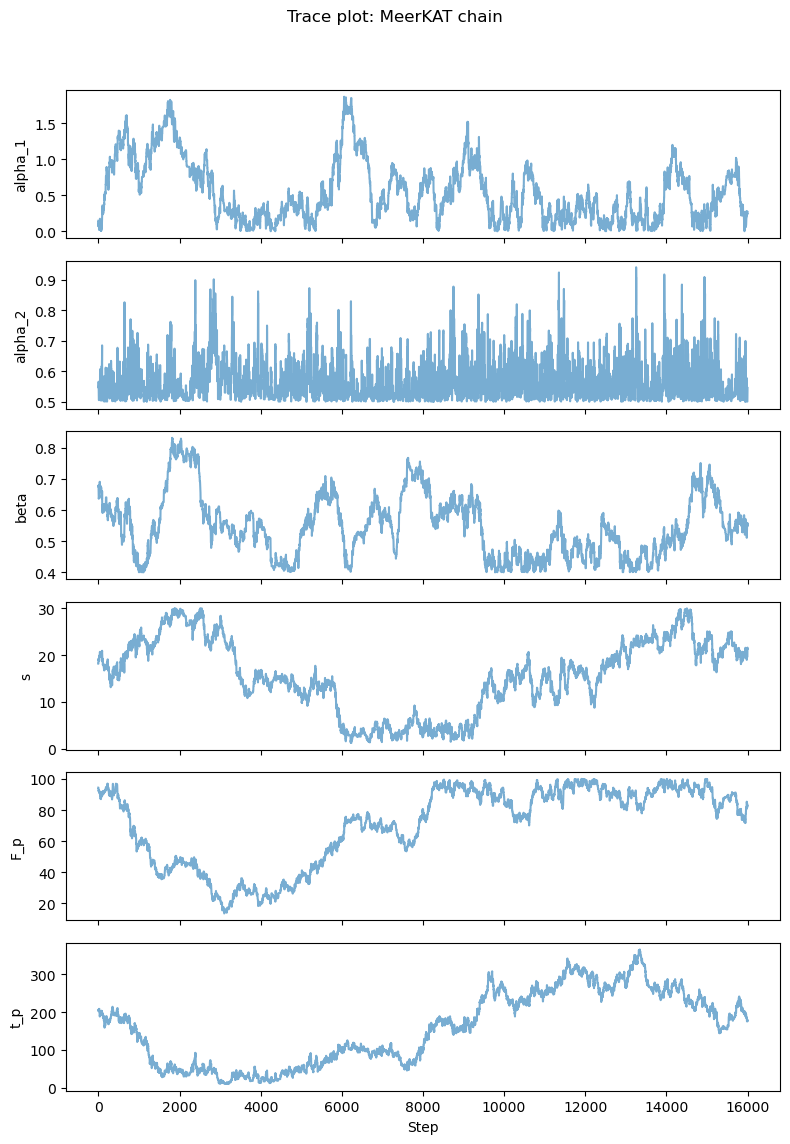

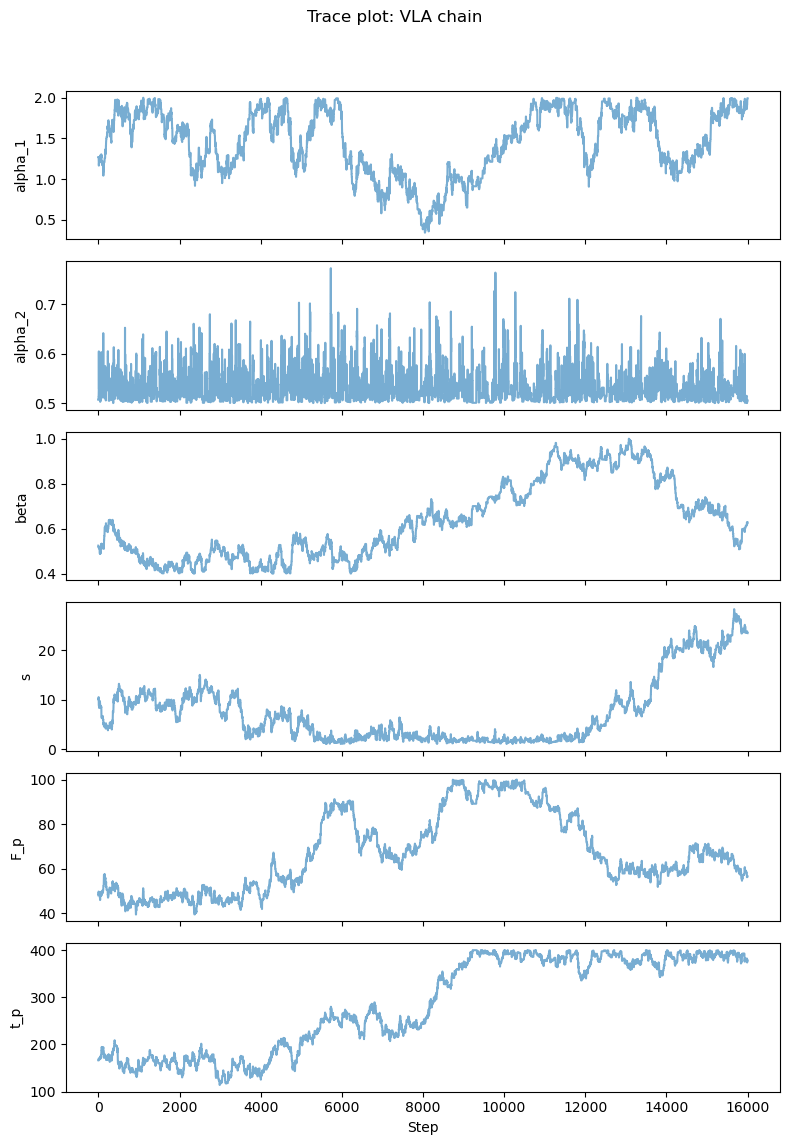

In [55]:
param_names = ['alpha_1', 'alpha_2', 'beta', 's', 'F_p', 't_p']

def plot_trace(samples, title):
    fig, axes = plt.subplots(len(param_names), 1, figsize=(8, 2*len(param_names)), sharex=True)
    for i, name in enumerate(param_names):
        axes[i].plot(samples[:, i], alpha=0.6)
        axes[i].set_ylabel(name)
    axes[-1].set_xlabel('Step')
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return fig  # Add this line

trace_plot_MeerKAT = plot_trace(samples_MeerKAT, "Trace plot: MeerKAT chain")
trace_plot_VLA = plot_trace(samples_VLA, "Trace plot: VLA chain")

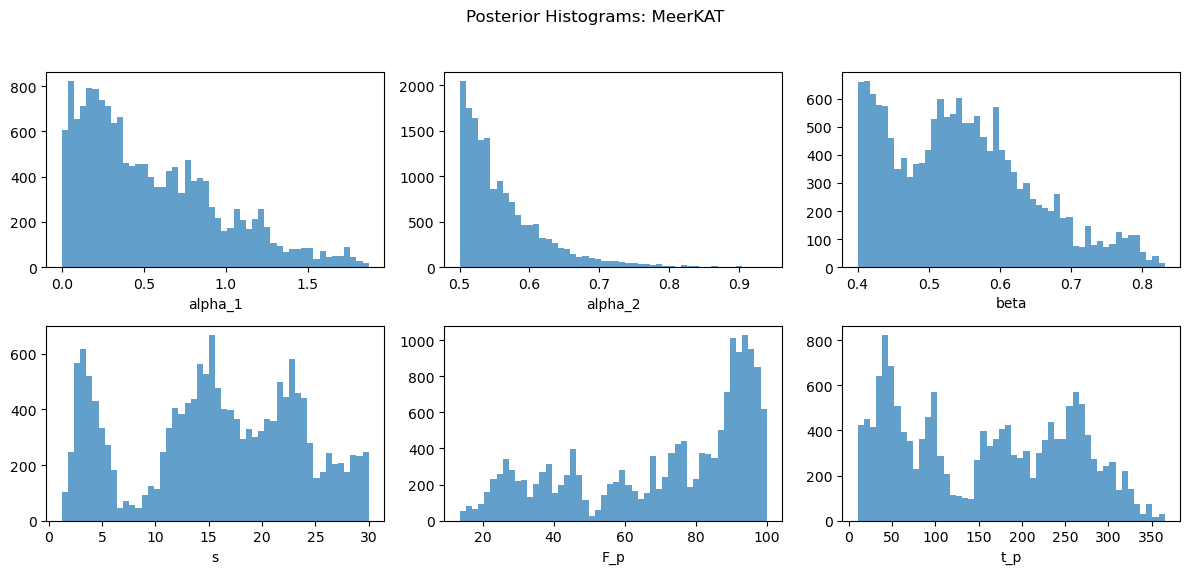

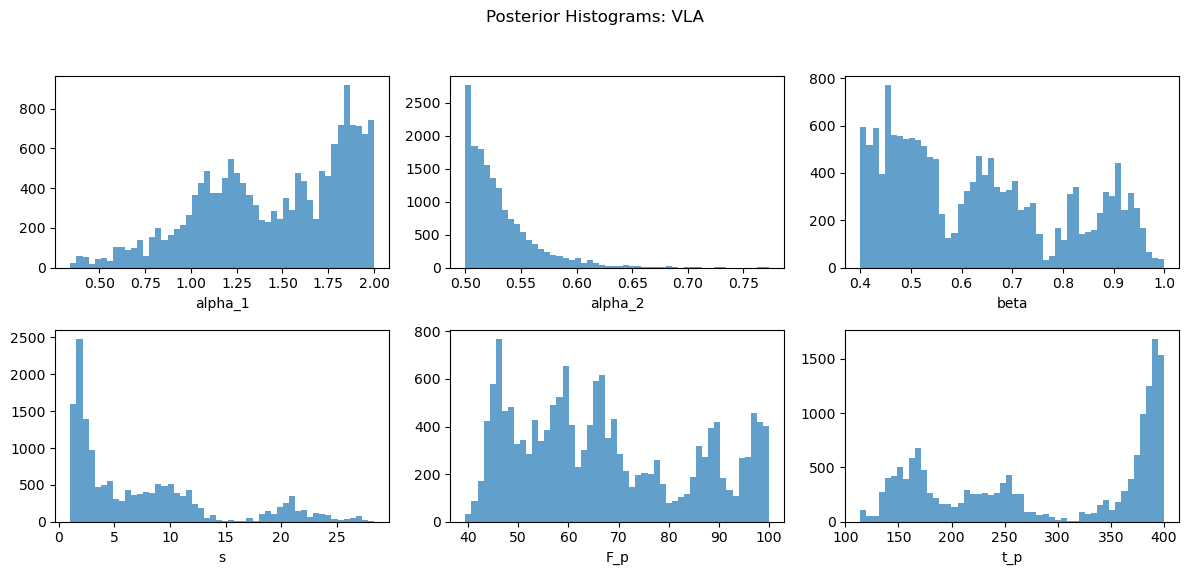

In [60]:
param_names = ['alpha_1', 'alpha_2', 'beta', 's', 'F_p', 't_p']

def plot_histograms(samples, title):
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    axes = axes.flatten()
    for i, name in enumerate(param_names):
        axes[i].hist(samples[:, i], bins=50, alpha=0.7)
        axes[i].set_xlabel(name)
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return fig  # Add this line to return the figure object

# Now use and save the figures as variables:
hist_MeerKAT = plot_histograms(samples_MeerKAT, "Posterior Histograms: MeerKAT")
hist_VLA = plot_histograms(samples_VLA, "Posterior Histograms: VLA")

hist_MeerKAT.savefig('posterior_hist_meerkat.png')
hist_VLA.savefig('posterior_hist_vla.png')

In [57]:
def summarize_samples_mean_std(samples, param_names):
    means = np.mean(samples, axis=0)
    stds = np.std(samples, axis=0)
    for i, name in enumerate(param_names):
        print(f"{name}: {means[i]:.3f} ± {stds[i]:.3f}")

print("MeerKAT fit: mean ± std")
summarize_samples_mean_std(samples_MeerKAT, param_names)

print("\nVLA fit: mean ± std")
summarize_samples_mean_std(samples_VLA, param_names)

MeerKAT fit: mean ± std
alpha_1: 0.548 ± 0.419
alpha_2: 0.562 ± 0.060
beta: 0.547 ± 0.099
s: 15.652 ± 7.813
F_p: 70.411 ± 25.112
t_p: 156.953 ± 96.449

VLA fit: mean ± std
alpha_1: 1.457 ± 0.397
alpha_2: 0.531 ± 0.031
beta: 0.632 ± 0.169
s: 7.425 ± 6.577
F_p: 67.151 ± 17.280
t_p: 284.370 ± 99.081


In [58]:
trace_plot_MeerKAT.savefig("trace_plot_meerkat.png")
trace_plot_VLA.savefig("trace_plot_vla.png")